In [1]:
!pip install transformers[torch] datasets jiwer

In [2]:
import os, google, warnings

warnings.filterwarnings('ignore')
google.colab.drive.mount('/content/drive')
working_dir = "/content/drive/MyDrive/Freelancing Colab Notebooks/writing-skill-improvement"
os.chdir(working_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch
import pandas as pd
from PIL import Image
from datasets import load_metric
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments,\
                         TrOCRProcessor, VisionEncoderDecoderModel, default_data_collator

In [4]:
df = pd.read_csv(f'{working_dir}/ocr/gt_test.txt', header=None, sep='\t')
df.rename(columns={
                    0: "file_name",
                    1: "text"
                    },
          inplace=True)
df['file_name'] = df['file_name'].apply(lambda x: x + 'g' if x.endswith('jp') else x)
df

,file_name,text
0,c04-110-00.jpg,Become a success with a disc and hey presto ! ...
1,c04-110-01.jpg,"assuredness "" Bella Bella Marie "" ( Parlophone..."
2,c04-110-02.jpg,I don't think he will storm the charts with th...
3,c04-110-03.jpg,"CHRIS CHARLES , 39 , who lives in Stockton-on-..."
4,c04-116-00.jpg,He is also a director of a couple of garages ....
...,...,...
2826,r03-053-04.jpg,"just dusty-grey but muddy , slimy even ."
2827,r03-053-05.jpg,"His digressions too , seemed to have no other"
2828,r03-053-06.jpg,purpose than the throwing of dust in his
2829,r03-053-07.jpg,"client's eyes , the dust of fake security , of"


In [5]:
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model.to("cuda")

print("Model and Processor Ready !!!")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Model and Processor Ready !!!


In [6]:
all_texts = df['text'].tolist()
all_texts = [text.lower() for text in all_texts]
all_tokens = [processor.tokenizer.tokenize(text) for text in all_texts]
all_token_lengths = [len(tokens) for tokens in all_tokens]
all_token_length_series = pd.Series(all_token_lengths)
all_token_length_series.describe(
    percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
)

count    2831.000000
mean       10.726598
std         7.956693
min         2.000000
25%         8.000000
50%        10.000000
75%        12.000000
90%        14.000000
95%        16.000000
99%        29.000000
max       186.000000
dtype: float64

In [7]:
# get idxs where max token length is less than 30
idxs = all_token_length_series[all_token_length_series <= 25].index.tolist()
df = df.iloc[idxs]
df

,file_name,text
0,c04-110-00.jpg,Become a success with a disc and hey presto ! ...
2,c04-110-02.jpg,I don't think he will storm the charts with th...
3,c04-110-03.jpg,"CHRIS CHARLES , 39 , who lives in Stockton-on-..."
4,c04-116-00.jpg,He is also a director of a couple of garages ....
5,c04-116-01.jpg,"writer . He writes with Tolchard Evans , compo..."
...,...,...
2826,r03-053-04.jpg,"just dusty-grey but muddy , slimy even ."
2827,r03-053-05.jpg,"His digressions too , seemed to have no other"
2828,r03-053-06.jpg,purpose than the throwing of dust in his
2829,r03-053-07.jpg,"client's eyes , the dust of fake security , of"


In [8]:
train_df, test_df = train_test_split(df, test_size=0.2)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [9]:
all_texts = df['text'].tolist()
all_texts = [text.lower() for text in all_texts]
all_tokens = [processor.tokenizer.tokenize(text) for text in all_texts]
all_token_lengths = [len(tokens) for tokens in all_tokens]
all_token_length_series = pd.Series(all_token_lengths)
all_token_length_series.describe(
    percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
)

count    2795.000000
mean       10.090877
std         3.054089
min         2.000000
25%         8.000000
50%        10.000000
75%        12.000000
90%        14.000000
95%        15.000000
99%        19.000000
max        25.000000
dtype: float64

In [10]:
class IAMDataset(Dataset):
    def __init__(
                self,
                root_dir,
                df,
                processor,
                max_target_length=30
                ):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values

        labels = self.processor.tokenizer(
                                          text,
                                          padding="max_length",
                                          max_length=self.max_target_length
                                          ).input_ids
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {
                    "pixel_values": pixel_values.squeeze(),
                    "labels": torch.tensor(labels)
                    }
        return encoding

In [11]:
train_dataset = IAMDataset(
                        root_dir='ocr/image/',
                        df=train_df,
                        processor=processor
                        )
eval_dataset = IAMDataset(
                        root_dir='ocr/image/',
                        df=test_df,
                        processor=processor
                        )

In [12]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 2236
Number of validation examples: 559


In [13]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([30])


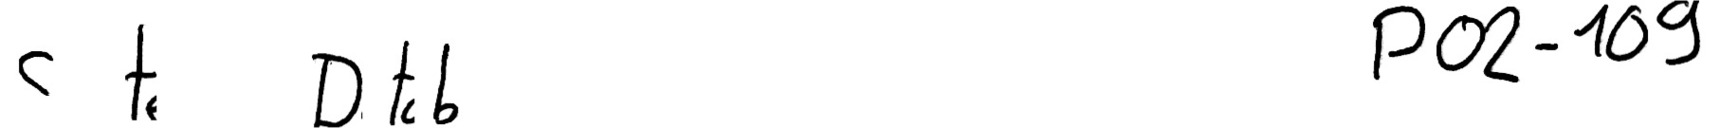

In [14]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][0]).convert("RGB")
image

In [15]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

Sentence Database P02-109


In [16]:
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 30
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

cer_metric = load_metric("cer")

In [17]:
training_args = Seq2SeqTrainingArguments(
                                        output_dir="./checkpoints",
                                        predict_with_generate=True,
                                        evaluation_strategy="steps",
                                        per_device_train_batch_size=4,
                                        per_device_eval_batch_size=4,
                                        fp16=True,
                                        logging_steps=8,
                                        save_steps=1000,
                                        eval_steps=300,
                                        # overwrite output dir
                                        overwrite_output_dir=True
                                        )

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [18]:
trainer = Seq2SeqTrainer(
                        model=model,
                        tokenizer=processor.feature_extractor,
                        args=training_args,
                        compute_metrics=compute_metrics,
                        train_dataset=train_dataset,
                        eval_dataset=eval_dataset,
                        data_collator=default_data_collator,
                        )
trainer.train()

Step,Training Loss,Validation Loss,Cer
300,2.733300,2.328941,0.346798
600,1.511800,1.777482,0.236881
900,1.125900,1.433662,0.187727
1200,0.445000,1.250349,0.157949
1500,0.387800,1.011066,0.120533


TrainOutput(global_step=1677, training_loss=1.5658962055552055, metrics={'train_runtime': 1566.6971, 'train_samples_per_second': 4.282, 'train_steps_per_second': 1.07, 'total_flos': 5.935878683033076e+18, 'train_loss': 1.5658962055552055, 'epoch': 3.0})

In [19]:
trainer.save_model("./checkpoints")